# Latam Airlines : Data Scientist Challenge
#### By: Aakruti Ambasana

In [32]:
import pandas as pd
import numpy as np
import re
import seaborn as sb
from matplotlib import pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, get_scorer_names, mean_squared_error

### Loading data

In [33]:
types = {'Vlo-I': 'string', 'Ori-I': 'category', 'Des-I': 'category', 
         'Emp-I': 'category', 'Vlo-O': 'string', 'Ori-O': 'category', 
         'Des-O': 'category', 'Emp-O': 'category', 'DIA': 'int', 'MES': 'int', 'AÑO': 'int', 
         'DIANOM': 'category', 'TIPOVUELO': 'string', 'OPERA': 'category', 'SIGLAORI': 'category', 
         'SIGLADES': 'category'}
path = "data/dataset_SCL.csv"
data = pd.read_csv(path, dtype=types, parse_dates=["Fecha-I","Fecha-O"])
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


- Vlo-I contains alpha numeric value.
- Vlo-O contains NaN null values.
- default is object type. object contains any kind of data like strings, integers, etc.
- string datatype contains string.

### Converting Vlo-I and Vlo-O into numeric values, as it contains flight number

- There are 16 data records in Vlo-O and 5 data records in Vlo-I which contains alpha numeric values.

In [34]:
print("Vlo-O:",data["Vlo-O"].str.contains("[A-Za-z]").sum())
print("Vlo-I:",data["Vlo-I"].str.contains("[A-Za-z]").sum())

Vlo-O: 16
Vlo-I: 5


In [35]:
# Replacing string with empty string
data["Vlo-I"] = data["Vlo-I"].str.replace(r"[A-Za-z]","", regex=True)
data["Vlo-O"] = data["Vlo-O"].str.replace(r"[A-Za-z]","", regex=True)

In [36]:
# Checking that Vlo-I, Vlo-O value does not contain any alphabet now.
print("After Vlo-O:",data["Vlo-O"].str.contains("[A-Za-z]").sum())
print("After Vlo-I:",data["Vlo-I"].str.contains("[A-Za-z]").sum())

After Vlo-O: 0
After Vlo-I: 0


### Dealing with missing data


In [37]:
print(data.isna().sum())

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64


In [38]:
# Vlo-O contains one row containing null value
print(data.loc[data['Vlo-O'].isna()])

                 Fecha-I Vlo-I Ori-I Des-I Emp-I             Fecha-O Vlo-O  \
6068 2017-01-19 11:00:00   200  SCEL  SPJC   LAW 2017-01-19 11:03:00  <NA>   

     Ori-O Des-O Emp-O  DIA  MES   AÑO  DIANOM TIPOVUELO  \
6068  SCEL  SPJC   56R   19    1  2017  Jueves         I   

                     OPERA  SIGLAORI SIGLADES  
6068  Latin American Wings  Santiago     Lima  


##### Assigning Vlo-I to Vlo-O because Ori-I is same as Ori-O, Des-I is same as Des-O, and if DIANOM is Jueves, there is very high chances that Vlo-I is same as Vlo-O, and there is no delay also.

In [39]:
data["Vlo-O"] = data["Vlo-O"].fillna(data["Vlo-I"])
data["Vlo-I"] = data["Vlo-I"].astype("int")
data["Vlo-O"] = data["Vlo-O"].astype("float")
data["Vlo-O"] = data["Vlo-O"].astype("int")

Some Vlo-O values are specified in **decimal** form but is integer. So, first converting into float and then int.

### Converting TIPOVUELO feature into integer
International flights are assigned with 1 and national flights are assigned with 0 values. 

In [40]:
data['TIPOVUELO'] = data['TIPOVUELO'].replace(['I', 'N'],[1,0]).astype("int")

### Data Analysis

In [41]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Vlo-I,68206.0,969.827288,2029.024762,1.0,150.0,300.0,632.0,9956.0
Vlo-O,68206.0,967.421092,2026.193621,1.0,150.0,300.0,637.5,9956.0
DIA,68206.0,15.714790,8.782886,1.0,8.0,16.0,23.0,31.0
MES,68206.0,6.622585,3.523321,1.0,3.0,7.0,10.0,12.0
AÑO,68206.0,2017.000029,0.005415,2017.0,2017.0,2017.0,2017.0,2018.0
TIPOVUELO,68206.0,0.458024,0.498239,0.0,0.0,0.0,1.0,1.0


Here, Vlo-I and Vlo-O values are skewed, because mean value is greater than 50%. There is big gap between 75% and max values of Vlo-I and Vlo-O features.

In [42]:
print(data.describe(include="category").T)

          count unique           top   freq
Ori-I     68206      1          SCEL  68206
Des-I     68206     64          SCFA   5787
Emp-I     68206     30           LAN  37611
Ori-O     68206      1          SCEL  68206
Des-O     68206     63          SCFA   5786
Emp-O     68206     32           LAN  20988
DIANOM    68206      7       Viernes  10292
OPERA     68206     23   Grupo LATAM  40892
SIGLAORI  68206      1      Santiago  68206
SIGLADES  68206     62  Buenos Aires   6335


- Ori-I, Ori-O, and SIGLAORI features contains only one value. So we will not include this features into input while training the model.
- Analyze Des-I, Desi-I, and SIGLADES which contains almost same number of categories. So some features can be duplicating. 
- Compare Emp-I, Emp-O and OPERA features. Keep the features which are useful, and remove the duplicate columns.

In [43]:
pd.crosstab(data["OPERA"],data["DIANOM"])

DIANOM,Domingo,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes
OPERA,,,,,,,
Aerolineas Argentinas,288,282,285,275,279,253,287
Aeromexico,52,52,51,48,50,50,48
Air Canada,108,82,101,66,47,94,67
Air France,54,50,52,51,49,51,51
Alitalia,22,52,52,50,1,51,31
American Airlines,104,104,117,104,112,115,101
Austral,15,16,0,13,0,30,0
Avianca,168,169,165,167,174,152,157
British Airways,40,12,11,39,51,12,40


**Maximum data contains of flights operated by LATAM Airlines.**

Some Airlines only fly on somes days of the week.
- Alitalia has only one flight on Miercoles but on other days of week approx. 50 flights are operated.
- Austral has no flights on Lunes, Miercoles, and Viernes.
- K.L.M. has less than 10 flights on Domingo and Viernes, while on other days of week it has approx 50 flights.
- Plus Ultra Lineas Aereas has flights on Lunes, Miercoles, and Viernes, while on other days of week it only have couple of flights.
- Quantas Airways has combined less than 10 flights on Jueves, Lunes, and Sabado, while on other days of week approx. 47 flights are operated.

array([[<AxesSubplot:title={'center':'Fecha-I'}>,
        <AxesSubplot:title={'center':'Vlo-I'}>,
        <AxesSubplot:title={'center':'Fecha-O'}>],
       [<AxesSubplot:title={'center':'Vlo-O'}>,
        <AxesSubplot:title={'center':'DIA'}>,
        <AxesSubplot:title={'center':'MES'}>],
       [<AxesSubplot:title={'center':'AÑO'}>,
        <AxesSubplot:title={'center':'TIPOVUELO'}>, <AxesSubplot:>]],
      dtype=object)

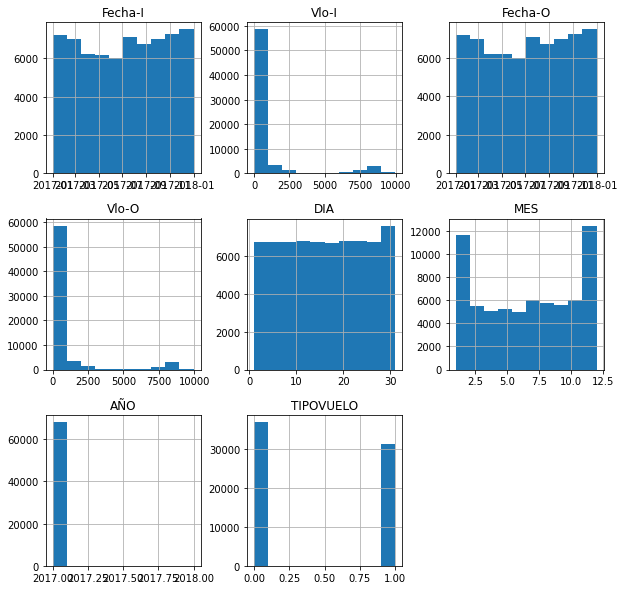

In [44]:
data.hist(figsize=(10,10))

In [45]:
print(data[['AÑO','TIPOVUELO']].value_counts())

AÑO   TIPOVUELO
2017  0            36966
      1            31238
2018  1                2
dtype: int64


**Insights from histogram**

- In MES, January and December month contains the highest number of flights operated. It is vacation time, so people travel a lot at that time.
- 54% flights are national, and 45% flights are international.
- AÑO is highly skewed and data is distributed more vertically. Because whole data is about 2017, only two data records are of 2018. 

## Q 1: Data Distribution

### Calculating Skew
- Skewness means data distibution is not uniform means it has less symmetry. The shape of curve represents the data distibution. 
- If curve is positively skewed then most of the values are less than median value. If curve is negatively skewed then most of the data is greater than median value. 
- The value zero mean data distribution is symmetric.

In [46]:
print(data.skew())

Vlo-I          3.093216
Vlo-O          3.103720
DIA            0.008439
MES           -0.063128
AÑO          184.665914
TIPOVUELO      0.168502
dtype: float64


**Observations**
- Vlo-I and Vlo-O are positively skewed. 
- AÑO is highly positivily skewed, because all data is from 2017 but only 2 data records from 2018. 
- Apparently, MES is slightly negatively skewed. DIA is closest to symmetric distribution.

### Calculating Kurtosis
Kurtosis measures peak point of curve of data. There are 3 types of curve: 
1. **Leptokurtic Curve:** This curve is **taller** than normal distribution curve. It value is greater than 0.
2. **Mesokurtic Curve:** This curve is closest to normal distribution curve. Its value is 0.
3. **Platykurtic Curve:** The peak of this curve is **flat**. It is flatter than other 2 curves. The value is less than 0.


In [47]:
print(data.kurtosis())

Vlo-I            8.099201
Vlo-O            8.162987
DIA             -1.192468
MES             -1.249906
AÑO          34100.499883
TIPOVUELO       -1.971665
dtype: float64


**Observations**
- Vlo-I and Vlo-O will be represented by leptokurtic curve means data distribution is more vertical.
- DIA and MES represents platykurtic curve means data is distributed more horizontally but it is closest to normal data distribution. 
- **Data distribution of AÑO is highly vertical represented by leptokurtic curve.**

### Data distribution for categorical features
To view data distribution of categorical features we need to plot the features.

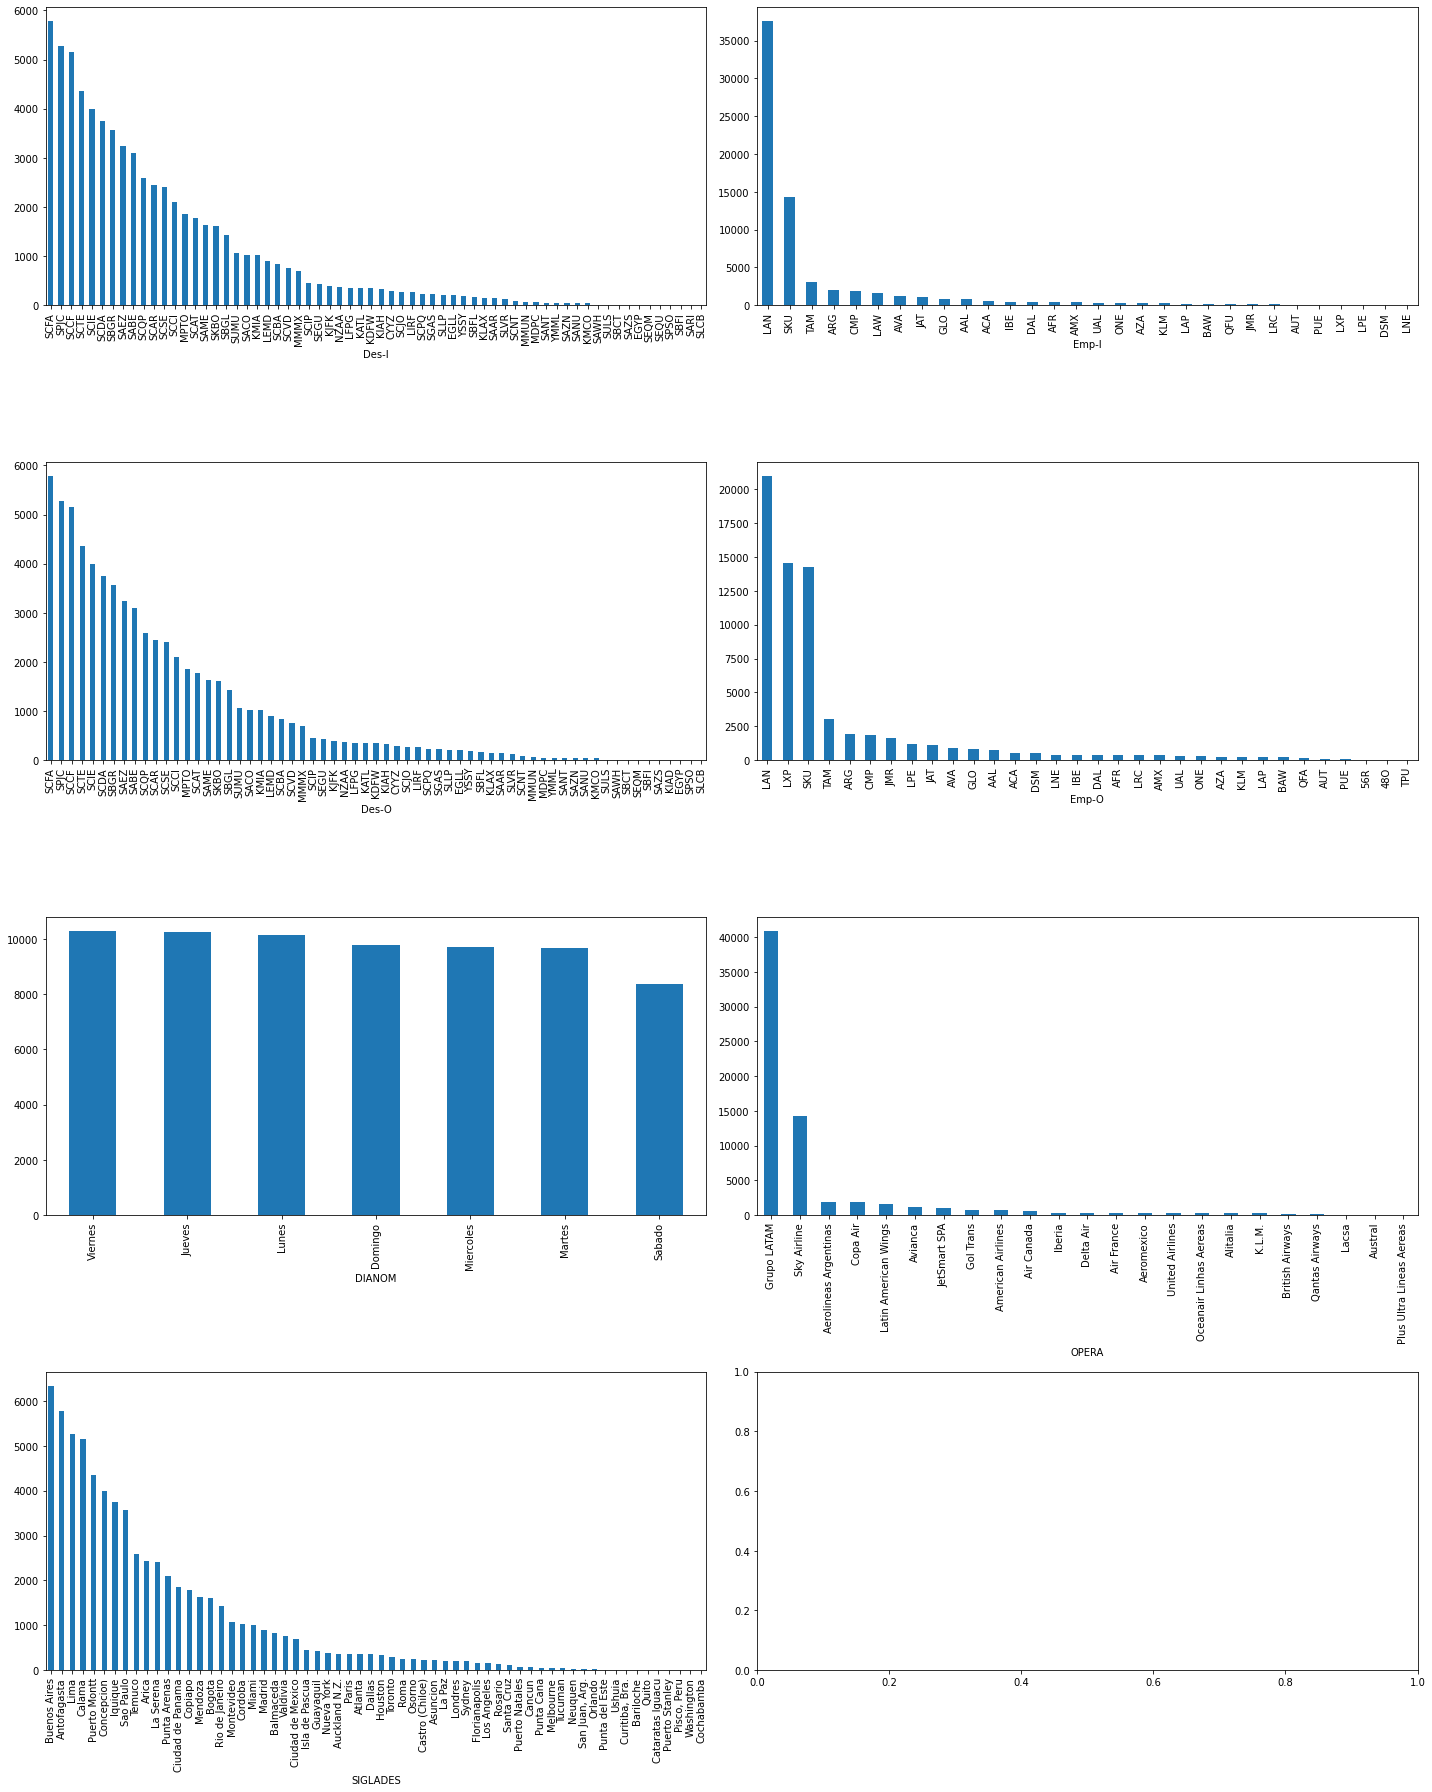

In [48]:

fig, axes = plt.subplots(4,2,figsize=(20,25))
data["Des-I"].value_counts().plot(kind="bar", xlabel="Des-I", ax=axes[0][0])
data["Emp-I"].value_counts().plot(kind="bar", xlabel="Emp-I", ax=axes[0][1])
data["Des-O"].value_counts().plot(kind="bar", xlabel="Des-O", ax=axes[1][0])
data["Emp-O"].value_counts().plot(kind="bar", xlabel="Emp-O", ax=axes[1][1])
data["DIANOM"].value_counts().plot(kind="bar", xlabel="DIANOM", ax=axes[2][0])
data["OPERA"].value_counts().plot(kind="bar", xlabel="OPERA", ax=axes[2][1])
data["SIGLADES"].value_counts().plot(kind="bar", xlabel="SIGLADES", ax=axes[3][0])
plt.tight_layout()
plt.show()


**Observations**

- Emp-I, Emp-O, and OPERA contains similar pattern in data. These features are highly skewed. 
- 60% of flights operated are of LATAM Airlines, 20% of flights are of Sky Airlines and rest 20% of flights are from 21 different airlines.
- DIANOM is very close to uniform distribution. It means there is approximately equal traffic on all days of week. 
- Des-I, Des-O, and SIGLADES contains similar data distribution.

## Q 2 Generating Synthetic features

- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- min_diff : difference in minutes between Date-O and Date-I .
- delay_15 : 1 if min_diff > 15, 0 if not.
- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based on Date-I 

#### Assumptions: 
* Considering scheduled date and time of the flight specified in Fecha-I as Date-I.
* Considering date and time of flight operated specified in Fecha-O as Date-O.

In [49]:
min_ts = data["Fecha-I"].min()
max_ts = data["Fecha-I"].max()
print("Fecha-I minimum date:",min_ts)
print("Fecha-I maximum date:",max_ts)

Fecha-I minimum date: 2017-01-01 00:15:00
Fecha-I maximum date: 2017-12-31 23:55:00


### Creating high_season feature

Considered dates between: 
- 2016-12-15 to 2017-03-03 : Because minimim date is 2017-01-01
- 2017-07-15 to 2017-07-31
- 2017-09-11 to 2017-09-30
- 2017-12-15 to 2018-03-03 : Because maximum date is 2017-12-31

In [50]:
fil1 = ((data["Fecha-I"]>=pd.Timestamp("2016-12-15")) & (data["Fecha-I"]<=pd.Timestamp("2017-03-03"))) | ((data["Fecha-I"]>=pd.Timestamp("2017-07-15")) & (data["Fecha-I"]<=pd.Timestamp("2017-07-31"))) | ((data["Fecha-I"]>=pd.Timestamp("2017-09-11")) & (data["Fecha-I"]<=pd.Timestamp("2017-09-30"))) | ((data["Fecha-I"]>=pd.Timestamp("2017-12-15")) & (data["Fecha-I"]<=pd.Timestamp("2018-03-03")))
data['high_season'] = fil1
data['high_season'] = data['high_season'].replace([True, False],[1,0])

### Creating minimum difference feature

Difference in minutes between Date-O and Date-I

In [51]:
data["min_diff"] = (data['Fecha-O']-data['Fecha-I']) / np.timedelta64(1,'m')

### Creating Delay feature

In [52]:
data["delay_15"] = data["min_diff"]>15
data["delay_15"] = data["delay_15"].replace([True, False],[1,0])

### Creating period of the day feature

In [53]:
data3 = pd.DataFrame()
data3['Date-I'] = data["Fecha-I"]
data3.set_index("Date-I", drop=False, inplace=True)
data3.loc[data3.between_time("05:00","11:59").index, "period_day"] = "morning"
data3.loc[data3.between_time("12:00","18:59").index, "period_day"] = "afternoon"
data3.loc[data3.between_time("19:00","04:59").index, "period_day"] = "night"
data["period_day"] = data3["period_day"].values

**Decisions**

- Drop Fecha-I and Fecha-O features because information this two features contained like delay time, season time, are extracted in new features. No need to repeat same information. Additionally, Fecha-I and Fecha-O are Timestamp and we require numerical data to train the model. 
- Drop Ori-I, Ori-O, and SIGLAORI features because it contains only one value. It will not contribute to learn any data patterns while training the model.

### Creating destination difference and flight difference features

- When scheduled flight code is different from operated flight, there are chances of delay. 
- When scheduled destination city code is different from operated city code, there are chances of delay.

In [54]:
# Categories cannot be compared with each other, if # of categories are not same. So, converted into string
data['Des-I'] = data['Des-I'].astype("string")
data['Des-O'] = data['Des-O'].astype("string")
data['Emp-I'] = data['Emp-I'].astype("string")
data['Emp-O'] = data['Emp-O'].astype("string")

# Destination difference feature
fil2 = (data['Des-I'] != data['Des-O'])
data['desti_diff'] = fil2
data['desti_diff'] = data['desti_diff'].replace([True, False],[1,0])

# Flight difference feature
fil3 = (data['Emp-I'] != data['Emp-O'])
data['flight_diff'] = fil3
data['flight_diff'] = data['flight_diff'].replace([True, False],[1,0])

# Category dtype consumes less memory and useful for one-hot encoding in future.
data['Des-I'] = data['Des-I'].astype("category")
data['Des-O'] = data['Des-O'].astype("category")
data['Emp-I'] = data['Emp-I'].astype("category")
data['Emp-O'] = data['Emp-O'].astype("category")

#### Exporting synthetic features

In [55]:
data[['high_season','min_diff','delay_15','period_day']].to_csv("data/synthetic_features.csv")